# TP 6a - GAN

This lab session will introduce you to Generative Adversial Network (GAN) with a toy problem. Starting from Fashion-MNIST dataset, we will try to generate new clothes ... from noise !

Note : here, he dataset will be accessed through torchvision

 

In [1]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import ToTensor, ToPILImage, Resize, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

#Load the data

fmnist = FashionMNIST(root='data', 
              train=True, 
              download=True, 
              transform=ToTensor())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("active device is : {}".format(device))

active device is : cuda:0


# Utility functions

In [2]:
# need to apply a denormalization to display images 
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# treat a mosaic of images with save/display option
def mosaic(imgs, display=True, save=False, name=''):
    plt.ioff()
    if not isinstance(imgs, list):
        imgs = [imgs]
    nb_imgs = len(imgs)
    n0 = np.ceil(np.sqrt(nb_imgs)).astype(int)
    fig, axs = plt.subplots(nrows=n0, ncols=n0, squeeze=False)
    for i, img in enumerate(imgs):
        img = ToPILImage()(img.detach())
        row, col = int(i / n0) , i % n0
        axs[row, col].imshow(np.asarray(img), cmap='gray')
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if save : 
      fig.savefig(name)
    if display : 
      plt.show()
    plt.close()

### Create the folders for savings images and models weights

In [3]:
import os
from os import path
from shutil import rmtree

# add your own path. Where to save the models
root_folder_GAN = '/content/drive/MyDrive/Lessons/Models/GAN/'
from google.colab import drive
drive.mount('/content/drive')

if path.exists(root_folder_GAN) :
  rmtree(root_folder_GAN)
os.makedirs(root_folder_GAN, exist_ok=True)
os.mkdir(path.join(root_folder_GAN, 'checkpoints'))
os.mkdir(path.join(root_folder_GAN, 'checkpoints', 'G'))
os.mkdir(path.join(root_folder_GAN, 'checkpoints', 'D'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Visualize data from the dataset



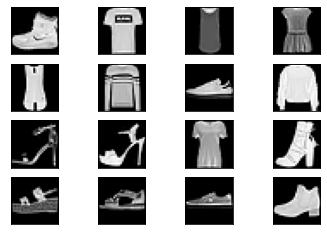

In [4]:
nb_images = 16
imgs = [fmnist[i][0] for i in range(nb_images)]
mosaic(imgs, save=True, name=os.path.join(root_folder_GAN, 'test.png'))

Images batch size = torch.Size([100, 1, 28, 28])


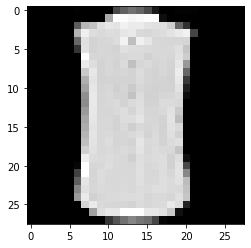

Labels batch = tensor([6, 2, 7, 3, 6, 8, 9, 1, 6, 9, 5, 0, 5, 4, 8, 6, 7, 9, 9, 0, 6, 0, 5, 8,
        7, 7, 3, 6, 5, 4, 6, 8, 2, 4, 0, 0, 8, 4, 2, 1, 6, 7, 9, 1, 6, 4, 8, 2,
        2, 8, 9, 4, 1, 3, 3, 3, 0, 7, 8, 6, 1, 8, 1, 6, 5, 3, 6, 1, 7, 9, 4, 3,
        2, 1, 4, 7, 3, 5, 0, 9, 7, 8, 7, 2, 2, 6, 5, 0, 3, 0, 7, 5, 0, 6, 9, 2,
        9, 5, 6, 4])


In [5]:
from torch.utils.data import DataLoader

# Create a Dataloader with batch_size of 100, shuffling data

batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)

for img_batch, label_batch in data_loader:
    print("Images batch size = {}".format(img_batch.shape))
    plt.imshow(img_batch[0][0], cmap='gray')
    plt.show()
    print("Labels batch = {}".format(label_batch))
    break
plt.close()

# Creation of the Discriminator and Generator models

### Discriminator ("Expert")

First, create a discriminator class based on a MLP model with :    
* flatten image input
* two (2) hidden layers of size *hidden_size*
* an output layer consistent with binary classification

Do not forget the activation ! Use : 
* nn.LeakyRELU(0.2) for hidden layers
* appropriate activation for output layer (binary classification) 

In [6]:
class Discriminator(nn.Module):
  def __init__(self, hidden_size):
    super(Discriminator, self).__init__()
    self.hidden_size = hidden_size
    self.linear1 = nn.Linear(image_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, 1)
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.leakyrelu(self.linear1(x))
    x = self.leakyrelu(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    return x

### Generator ("Counterfeiter")

Second, create a generator class based on a MLP model with :    
* an input (latent variable) as vector of dimension *latent_size*
* two (2) hidden layers of size *hidden_size*
* an output layer generating a vector of dimension *image_size* (= 28*28)

Do not forget the activation ! Use : 
* nn.ReLU() for hidden layers
* appropriate activation for output layer (pixel value in range [0,1]) 

In [7]:
class Generator(nn.Module):
  def __init__(self, latent_size, hidden_size, image_size):
    super(Generator, self).__init__()
    self.latent_size = latent_size
    self.hidden_size = hidden_size
    self.image_size = image_size
    self.linear1 = nn.Linear(latent_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, image_size)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.sigmoid(self.linear3(x))
    return x

### Models instantiation & casting

In [8]:
image_size = 28 * 28
hidden_size = 256
latent_size = 64

D = Discriminator(hidden_size)
G = Generator(latent_size, hidden_size, image_size)

D.to(device)
G.to(device)

Generator(
  (linear1): Linear(in_features=64, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

### Seeds generation and visualization

Create a batch of 9*9=81 vectors in the latent space. Use this batch to generate image from the generator model G and visualize the result. 

What do you observe ? 

tensor([[0.5232],
        [0.5235],
        [0.5237],
        [0.5233],
        [0.5233],
        [0.5232],
        [0.5232],
        [0.5237],
        [0.5235],
        [0.5235],
        [0.5236],
        [0.5234],
        [0.5236],
        [0.5236],
        [0.5236],
        [0.5236],
        [0.5235],
        [0.5232],
        [0.5232],
        [0.5234],
        [0.5235],
        [0.5236],
        [0.5233],
        [0.5234],
        [0.5233],
        [0.5235],
        [0.5239],
        [0.5235],
        [0.5234],
        [0.5235],
        [0.5235],
        [0.5232],
        [0.5233],
        [0.5230],
        [0.5237],
        [0.5237],
        [0.5237],
        [0.5236],
        [0.5235],
        [0.5234],
        [0.5233],
        [0.5232],
        [0.5232],
        [0.5236],
        [0.5236],
        [0.5238],
        [0.5231],
        [0.5238],
        [0.5234],
        [0.5232],
        [0.5235],
        [0.5234],
        [0.5231],
        [0.5237],
        [0.5235],
        [0

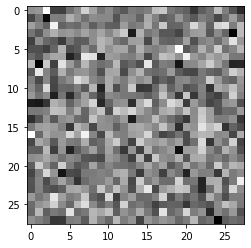

In [9]:
seed = torch.randn(81, latent_size).to(device)

y = G(seed)
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
print(D(gen_imgs))

plt.imshow(gen_imgs[0].cpu(), cmap='gray');
plt.show()
plt.close()

# Models training

### Discriminator loss criterion definition and optimizer

In [10]:
d_criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

### Discriminator training loop

In [18]:
#Training the discriminator
    
def train_discriminator(images):
    # set model(s) in appropriate mode (train or eval)
    G.eval()
    D.train()
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    real_scores = D(images)
    d_loss_real = d_criterion(real_scores, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_scores = D(fake_images)
    d_loss_fake = d_criterion(fake_scores, fake_labels)
    
    # So essentially, you use the given set of real images and feed it to the discriminator and train to understand the pattern of the real images.
    # Then, you generate a bunch of fake images and then feed them to the discriminator to train them to understand the pattern of the fake images.

    # Combine losses (on real images and fake images)
    d_loss = d_loss_real + d_loss_fake

    # Backpropagation and weights update
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_scores, fake_scores

### Generator loss criterion definition and optimizer

In [12]:
g_criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

### Generator training loop

In [13]:
def train_generator():
    # set model(s) in appropriate mode (train or eval)
    G.train()

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    g_loss = g_criterion(D(fake_images), real_labels)

    # Backprop and optimize
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

In [14]:
def eval_generator():
    # a function to evaluate the geneartor by creating "fake" images and returning them as imgs
    G.eval()
    gen_imgs = G(seed.to(device)).reshape((-1, 28,28)).detach()
    imgs = [gen_imgs[i] for i in range(gen_imgs.shape[0])]
    return imgs

# Training loop

Run the training for 50 epochs (~8 minutes with GPU environment)

In [19]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    if epoch % 5 == 0 :
       imgs = eval_generator()
       mosaic(imgs, display=False, save=True, name=root_folder_GAN + 'epoch{:04}.png'.format(epoch))
    
    if epoch % 25 == 0 : 
       torch.save(G.state_dict(), root_folder_GAN + '/checkpoints/G/epoch{:04}.ckpt'.format(epoch))
       torch.save(D.state_dict(), root_folder_GAN + '/checkpoints/D/epoch{:04}.ckpt'.format(epoch))

Epoch [0/50], Step [200/600], d_loss: 0.0425, g_loss: 4.4697, D(x): 0.98, D(G(z)): 0.02
Epoch [0/50], Step [400/600], d_loss: 0.0814, g_loss: 6.4339, D(x): 0.97, D(G(z)): 0.03
Epoch [0/50], Step [600/600], d_loss: 0.0448, g_loss: 5.3987, D(x): 0.97, D(G(z)): 0.01
Epoch [1/50], Step [200/600], d_loss: 0.0025, g_loss: 7.2504, D(x): 1.00, D(G(z)): 0.00
Epoch [1/50], Step [400/600], d_loss: 0.0210, g_loss: 7.5618, D(x): 0.99, D(G(z)): 0.00
Epoch [1/50], Step [600/600], d_loss: 0.0495, g_loss: 5.8728, D(x): 0.99, D(G(z)): 0.01
Epoch [2/50], Step [200/600], d_loss: 0.0504, g_loss: 8.9009, D(x): 0.99, D(G(z)): 0.03
Epoch [2/50], Step [400/600], d_loss: 0.0479, g_loss: 8.0369, D(x): 0.98, D(G(z)): 0.00
Epoch [2/50], Step [600/600], d_loss: 0.0217, g_loss: 6.4526, D(x): 0.99, D(G(z)): 0.01
Epoch [3/50], Step [200/600], d_loss: 0.1306, g_loss: 5.9532, D(x): 0.96, D(G(z)): 0.00
Epoch [3/50], Step [400/600], d_loss: 0.0420, g_loss: 7.2407, D(x): 0.98, D(G(z)): 0.00
Epoch [3/50], Step [600/600], d_

Plot the Generator and Discriminator losses over training

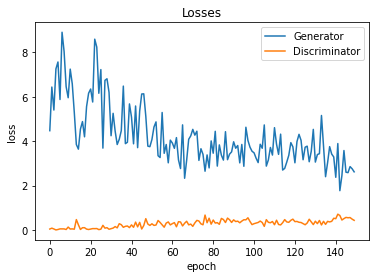

In [20]:
plt.plot(g_losses, '-')
plt.plot(d_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Generator', 'Discriminator'])
plt.title('Losses');
plt.show()

Plot the scores (fake and real) over training

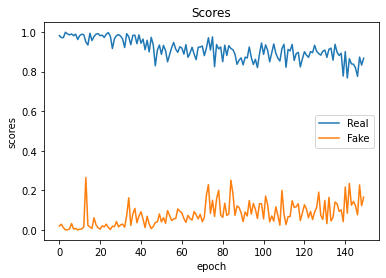

In [21]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('scores')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
plt.show()

# BONUS

How would you modify the Discriminator & Generator to better deal with images ? 

Try and check if you can improve performances ! 